<a href="https://colab.research.google.com/github/ccsammut/SIT796/blob/main/SIT796_7_1_CSammut500173318.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#relevant installations
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet
!pip install pulp
!pip install mdp
!pip install utils
!pip install gym
!pip install pygame

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from tqdm import tqdm
from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display
from utils import *
from collections import defaultdict
from math import pi
from tqdm import tqdm

import base64
import io
import IPython
import math, copy
import gym
import itertools
import pandas as pd
import sys
import time
import timeit
import statistics
from collections import namedtuple
import os

%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm


In [3]:
#defining the environment for all models
environment = "Pendulum-v0"

**Copy of the Tiles3 program to run within the notebook.**

**Reference:**

SUTTON, R. S. Tile Coding Software -- Reference Manual, Version 3.0 [Online]. Reinforcement Learning and Artificial Intelligence (RLAI): incompleteideas.net. Available: http://incompleteideas.net/tiles/tiles3.html [Accessed 4 May 2022].

In [4]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


In [5]:
# Tile Coding Class - setting up the tile coding for the environment

class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        
        #initialising all of the tile coding initialisers and varaibles
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity):

        #To scale the inpuit for the tiles3 program, set the max and min of position (theta) and velocity
        POSITION_MIN = -pi
        POSITION_MAX = pi
        VELOCITY_MIN = -8
        VELOCITY_MAX = 8
        
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        
        # Retreive and return active tiles
        tiles2 = tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale])
        
        return np.array(tiles2)

In [6]:
#Functions to use for both models to transplate information from the environemnt to be used in our program

#convert x and y coordinates from the environement observations inot a theta value to be used as position
def find_theta(x, y):
  theta = round((np.arctan(y/x)), 1)
  if theta > 3:
    theta = round((theta-3),1)
  if theta < -3.1:
    theta = round((theta+3.1),1)
  else:
    theta
  return theta

#converts an observation from the environment into a usable position, (angular)velocity tuple
def get_state(obs):
  x = obs[0]
  y = obs[1]
  w = round(obs[1])
  theta = find_theta(x, y)
  state = (theta, w)
  return state

#functions to discretise the action space
def generate(lower_bound, upper_bound, interval):
    output = []
    while lower_bound <= upper_bound:
        output.append( int( round(lower_bound,1) + 0 ) )
        lower_bound += interval
    return output

def generate_actions(a_approx):
    actions = []
    for a in a_approx:
        actions.append(a)
    return actions

In [7]:
#creating a dictionary of discrete actions
a_approx = generate(-2, 2, 1)
actions = generate_actions(a_approx)
action_ref = {}
n=-1
for a in actions:
    action_ref.update({n+1:a})
    n+=1

print(action_ref)

{0: -2, 1: -1, 2: 0, 3: 1, 4: 2}


In [8]:
#Defining parameter values to be used for both models
epsilon = 0.1
alpha = 0.1
gamma = 0.9
lambda1 = 0.1
number_actions = 5

In [9]:
# Semi Graient Descent class
class SGDAgent():
    #initialising the agent
    def __init__(self, agent_info={}):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.pntc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    #setting inital values
    def agent_init(self, agent_info={}):
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", epsilon)
        self.gamma = agent_info.get("gamma", gamma)
        self.alpha = agent_info.get("alpha", alpha) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", number_actions)
        
  

        # Initialise weight vector w
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights
        
        # Initialise tile coder
        self.pntc = PendulumTileCoder(iht_size = self.iht_size, 
                                         num_tilings = self.num_tilings, 
                                         num_tiles = self.num_tiles)

    #Choose action using epsilon greedy
    def select_action(self, tiles):
        
        #Set up variables
        action_values = []
        chosen_action = None
        
        #Generate action values for all actions 
        #initally w=1 so has no impact for agent start
        action_values = np.sum(self.w[:, tiles], axis = 1)
        
        # Epsilon Greedy action selecion
        if np.random.random() < self.epsilon:
            # Select random action among the five posible actions
            ca = np.random.randint(self.num_actions)
            #convert random index to action value
            chosen_action = action_ref[ca]
        else:
            # Select the greedy action
            ca = np.argmax(action_values)
            chosen_action = action_ref[ca]
        
        return chosen_action, action_values[ca]

    #First action
    def agent_start(self, state):

        #current state
        theta, velocity = state
        
        #tiles activated at state 
        active_tiles = self.pntc.get_tiles(position = theta, velocity = velocity)
        
        #action values of the state
        current_action, action_value = self.select_action(active_tiles)

        #last action
        self.last_action = current_action

        #save previous tiles
        self.previous_tiles = np.copy(active_tiles)
        
        return self.last_action

    #SGD agent step with Sarsa weight updates
    def agent_step(self, reward, state):

        # Current state
        theta, velocity = state

        # Compute current tiles
        active_tiles = self.pntc.get_tiles(position = theta, velocity = velocity)
        # Obtain new action and action value before updating action values
        current_action, action_value = self.select_action(active_tiles)
        
        # Update the Sarsa Target (delta)
        target = reward + (self.gamma * action_value)
        
        # Compute last action values to update weights
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles]) 
        
        # As we are using tile coding, which is a variant of linear function approximation
        # The gradient of the active tiles are one, otherwise zero.
        grad = 1
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad
                
        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    #SGD agent step without weight udpates
    def agent_step2(self, reward, state):

        # Current state
        theta, velocity = state

        # Compute current tiles
        active_tiles = self.pntc.get_tiles(position = theta, velocity = velocity)
        # Obtain new action and action value before updating action values
        current_action, action_value = self.select_action(active_tiles)

        self.last_action = current_action
        return self.last_action

    #Sarsa agent end updating weight vector
    def agent_end(self, reward):

        # adjust target
        target = reward 
        # last action value
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])
        grad = 1
        # Update w
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad

    #Max action values    
    def return_action_value(self, state):
        # Current state
        theta, velocity = state
        
        # Obtain tiles activated at state cero
        active_tiles = self.pntc.get_tiles(position = theta, velocity = velocity)
        # Obtain action values for all actions (sum through rows)
        action_values = np.sum(self.w[:, active_tiles], axis = 1)
        # Obtain max action value
        max_action_value = np.max(action_values)
        
        return max_action_value

In [10]:
# Test Sarsa Agent 
num_runs = 10
num_episodes = 100
agent_info_options = {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096,
                      "epsilon": epsilon, "gamma": gamma, "alpha": alpha,
                      "initial_weights": 0.0, "num_actions": number_actions}

# Variable to store the amount of steps taken to solve the challenge
all_steps = []
# Variable to save the rewards in an episode
all_rewards = []

# Agent
agent = SGDAgent(agent_info_options)

# Environment
env = gym.make(environment)
env.reset()
# Maximum number of possible steps in an episode (defined by the environement)
#env._max_episode_steps = 200

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation = env.reset()
    # Reset agent
    agent.agent_init(agent_info_options)
    # Generate last state and action in the agent
    state = get_state(observation)
    last_action = agent.agent_start(state)

    # Steps taken at each episode to solve the challenge
    steps_per_episode = []
    rewards_per_episode = []
        
    # Times the environment will start again without resetting the agent
    for t in range(num_episodes):
        # Store number of steps taken to solve experiment
        n_steps = 0
        rewards = 0
        # Reset done flag
        done = False
        # Reset environment
        observation = env.reset()
        # Run until the experiment is over
        while not done:

            # Take a step with the environment
            observation, reward, done, info = env.step(np.array([last_action]))
            
            # Number of steps the agent take to solve the challenge
            n_steps += 1
            # Accumulate reward
            rewards += reward

            # If the goal has been reached stop
            if done:
                # Last step with the agent
                agent.agent_end(reward)
                
            else:
                # Take a step with the agent
                state = get_state(observation)
                last_action = agent.agent_step(reward, state)
                
        # Save the amount of steps needed to complete the experiment 
        # Without rebooting the agent
        steps_per_episode.append(n_steps)
        # Save the amount of award obtained at each episode
        rewards_per_episode.append(rewards)
        
    # all steps per episode
    all_steps.append(np.array(steps_per_episode))
    # all rewards per episode
    all_rewards.append(np.array(rewards_per_episode))

env.close()


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


In [11]:
# Test TD
num_runs = 10
num_episodes = 100
TD_agent_info_options = {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096,
                      "epsilon": epsilon, "gamma": gamma, "alpha": alpha,
                      "initial_weights": 0.0, "num_actions": number_actions}

# Variable to store the amount of steps taken to solve the challeng
TD_all_steps = []
# Variable to save the rewards in an episode
TD_all_rewards = []

# Agent
TDagent = SGDAgent(TD_agent_info_options)

# Environment
env = gym.make(environment)
env.reset()

gamma = TD_agent_info_options['gamma'] #trace decay
alpha = TD_agent_info_options['alpha'] #step size
lmbda = lambda1



# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation = env.reset()
    # Reset agent
    TDagent.agent_init(TD_agent_info_options)
    # Generate last state and action in the agent
    state = get_state(observation)
    last_action = TDagent.agent_start(state)
    # Steps taken at each episode to solve the challenge
    TD_steps_per_episode = []
    TD_rewards_per_episode = []

    w = defaultdict(float) #is weight
    
    for episode in range(num_episodes):
        TD_n_steps = 0
        TD_rewards = 0
        z = defaultdict(float) #initalise to zero
        obs = env.reset() #reset env, initlaise state
        for t in range(1000): #loop for each step
            # sample action from the policy
            state = get_state(obs)
            action = TDagent.agent_start(state)#get action according to policy
                                    
            # the environment effects after taking action
            n_state, reward, done, _ = env.step(np.array([action])) #take a step with action
            next_state = get_state(n_state)
            z[state] += 1 #update z
            TD_n_steps += 1
            # Accumulate reward
            TD_rewards += reward
          

            td_error = reward + (gamma * w[next_state]) - w[state] #calculate error (delta)
            
            # online update value function
            for s, value in w.items():
                w[s] = w[s] + alpha * td_error * z[s] #update weight vector
                z[s] = gamma * lmbda * z[s] #update z vector
            if done:
                break
                
            state = next_state
           
        # Save the amount of steps in an episode
        TD_steps_per_episode.append(TD_n_steps)
        # Save the amount of reward obtained at each episode
        TD_rewards_per_episode.append(TD_rewards)

    # all steps per episode
    TD_all_steps.append(np.array(TD_steps_per_episode))
    # all rewards per episode
    TD_all_rewards.append(np.array(TD_rewards_per_episode))

env.close()


100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


In [12]:
# Run Sarsa Agent 
num_runs = 1
num_episodes = 100
num_steps = 200

env.close
!rm ./vid/*.*

d = Display()
d.start()

# Environment
env_to_wrap = gym.make(environment)
env = Monitor(env_to_wrap, "./videos/Pendulum", video_callable=lambda episode_id: True, force=True)
o = env.reset()
env.render()

#Initialising the variables
rew_perep = []
steps_perep = []
epi_count = []
rew = 0
total_step_count = 0

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
  
    state=get_state(o)
    # Generate last state and action in the agent
    last_action = agent.agent_start(state)
    theta, angle = state
    # Resets environment
    observation = env.reset()
    
    # Times the environment will start again in an episode
    for n_runs in tqdm(range(num_runs)):

      # Generate last state and action in the agent
      state=get_state(observation)
      last_action = agent.agent_start(state)
      step_count = 0
      rew_ep = 0
      ep_count = 0
      # Times the environment will start again in an episode
      for t in tqdm(range(num_episodes)):

        ep_count += 1
        epi_count = np.append(epi_count, ep_count)

        for x in range(num_steps):

          # Take a step with the environment
          observation, reward, done, info = env.step(np.array([last_action]))
          step_count += 1
          rew_ep += int(reward)
          rew += reward
          total_step_count += 1
          
          # If the goal has been reached then stop
          if done:
            # Last step with the agent
            agent.agent_end(reward)
            env.reset()
            break

          else:
            # Take a step with the agent
            state=get_state(observation)
            last_action = agent.agent_step(reward, state)
        #update the episode monitoring values
        ave_rew_ep = rew_ep/ep_count
        rew_perep = np.append(rew_perep, ave_rew_ep)
        steps_perep = np.append(steps_perep, step_count)

#closing the environnment     
env.close()
env_to_wrap.close()

#update the method monitoring values      
ave_rew_step = rew/step_count
ave_rew = sum(rew_perep)/num_episodes

print('The average reward per step is {}'.format(ave_rew_step))
print('The average reward per episode is {}'.format(ave_rew))


rm: cannot remove './vid/*.*': No such file or directory


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<03:28,  2.10s/it]

  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

  3%|▎         | 3/100 [00:06<03:23,  2.10s/it]

  4%|▍         | 4/100 [00:08<03:20,  2.08s/it]

  5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

  6%|▌         | 6/100 [00:12<03:16,  2.09s/it]

  7%|▋         | 7/100 [00:14<03:14,  2.10s/it]

  8%|▊         | 8/100 [00:16<03:12,  2.09s/it]

  9%|▉         | 9/100 [00:18<03:09,  2.08s/it]

 10%|█         | 10/100 [00:20<03:07,  2.08s/it]

 11%|█         | 11/100 [00:22<03:04,  2.08s/it]

 12%|█▏        | 12/100 [00:25<03:03,  2.08s/it]

 13%|█▎        | 13/100 [00:27<03:01,  2.08s/it]

 14%|█▍        | 14/100 [00:29<02:58,  2.08s/it]

 15%|█▌        | 15/100 [00:31<02:55,  2.06s/it]

 16%|█▌        | 16/100 [00:33<02:51,  2.05s/it]

 17%|█▋        | 17/100 [00:35<02:52,  2.07s/it]

 18%|█▊        | 18/100 [00:37<02:50,  2.08s/it]

 19%|█▉        | 19/100 [00:3

The average reward per step is -6.020740097940455
The average reward per episode is -1126.7294229642985


In [ ]:
#**Run this code cell to produce videos of each SARSA agent episode**

'''
#playing the viedoe of each episode from the sarsa agent
for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))
'''

In [14]:
# Run TD Agent 
num_runs = 1
num_episodes = 100
num_steps = 200

env.close
!rm ./vid/*.*

d = Display()
d.start()

# Environment
env_to_wrap2 = gym.make(environment)
env2 = Monitor(env_to_wrap2, "./videos/Pendulum", video_callable=lambda episode_id: True, force=True)
o = env2.reset()
env2.render()

#Initialising the variables
TD_rew_perep = []
TD_steps_perep = []
TD_epi_count = []
TD_rew = 0
TD_total_step_count = 0

# Number of runs are the number of episodes
for n_runs in tqdm(range(num_runs)):

    # Resets environment
    state=get_state(o)
    # Generate last state and action in the agent
    last_action = TDagent.agent_start(state)
    theta, angle = state
    observation = env2.reset()
    
    # Generate last state and action in the agent
    state=get_state(observation)
    last_action = TDagent.agent_start(state)
    #initialise counters
    TD_step_count = 0
    TD_rew_ep = 0
    TD_ep_count = 0
    #initlaise the weight  
    w = defaultdict(float)

    for t in tqdm(range(num_episodes)):
            TD_ep_count += 1
            TD_epi_count = np.append(TD_epi_count, TD_ep_count)
            z = defaultdict(float) #E is z - initalise to zero
            obs = env.reset() #rest env, initlaise state
            for t in range(1000): #loop for each step
                # sample action from the e-greedy policy
                state = get_state(obs)
                action = TDagent.agent_start(state)#get action according to policy
                                    
                # environments' effects after taking action
                obs, reward, done, _ = env2.step(np.array([action])) #take a step with action
                next_state = get_state(obs)
              
                z[state] += 1 #update z
                
                #count reward and steps
                TD_rew += reward
                TD_rew_ep += int(reward)
                TD_step_count += 1
          
                td_error = reward + (gamma * w[next_state]) - w[state] #claculate error (delta)
            
                # online update value function
                for s, value in w.items():
                    w[s] = w[s] + alpha * td_error * z[s] #update weight vector
                    z[s] = gamma * lmbda * z[s] #update z vector
                #if the goal has been reached or the max steps have been taken then end the episode
                if done:
                    #TDagent.agent_end(reward)
                    env2.reset()
                    break
                #otherwise take a step
                else:
                  state=get_state(obs)
                  last_action = TDagent.agent_step2(reward, state)
           
            TD_ave_rew_ep = TD_rew_ep/TD_ep_count
            TD_rew_perep = np.append(TD_rew_perep, TD_ave_rew_ep)
            TD_steps_perep = np.append(TD_steps_perep, TD_step_count)

 
env2.close()
env_to_wrap2.close()
        
TD_ave_rew_step = TD_rew/TD_step_count
TD_ave_rew = sum(TD_rew_perep)/num_episodes


print('The average reward per step is {}'.format(TD_ave_rew_step))
print('The average reward per episode is {}'.format(TD_ave_rew))



rm: cannot remove './vid/*.*': No such file or directory


100%|██████████| 1/1 [03:39<00:00, 219.53s/it]

The average reward per step is -7.233133513007549
The average reward per episode is -1346.4869941964746


In [ ]:
#**Run this code cell to produce videos of each TDL agent episode**

'''
#playing the viedoe of each episode from the TDL agent
for f in env2.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.


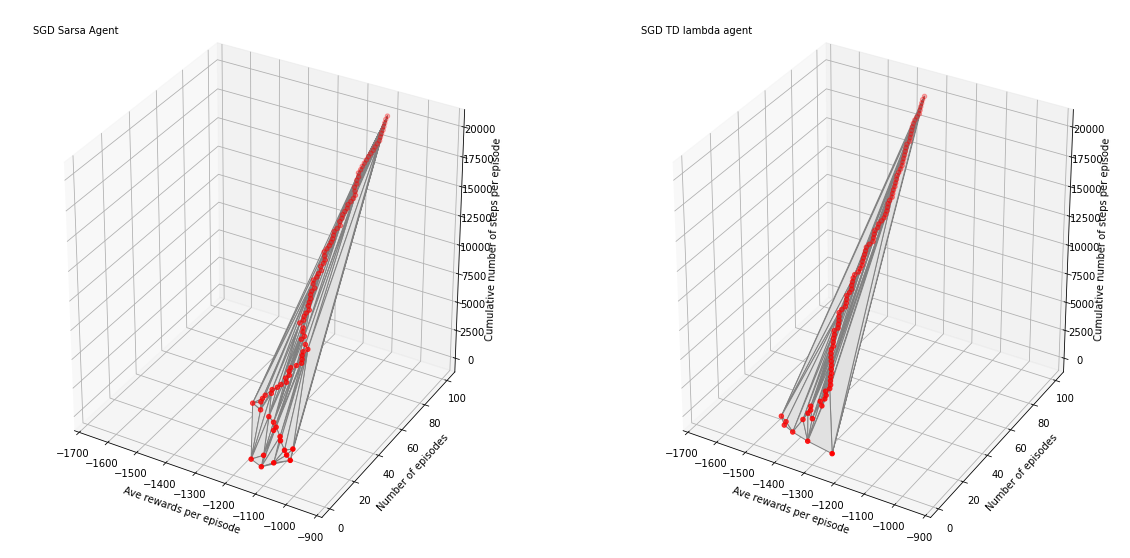

In [16]:
#ploting average rewards over 100 episodes as a function of the necessary number of steps


# Plot X,Y,Z
X1=rew_perep
Y1=epi_count
Z1=steps_perep
X=TD_rew_perep
Y=TD_epi_count
Z=TD_steps_perep


import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data

fig = plt.figure(figsize=(20,10))

# =============
# Sarsa agent plot
# =============
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(X1, Y1, Z1, color='white', edgecolors='grey')
ax.text2D(0.05, 0.95, "SGD Sarsa Agent", transform=ax.transAxes)
ax.set_xlabel('Ave rewards per episode')
ax.set_ylabel('Number of episodes')
ax.set_zlabel('Cumulative number of steps per episode')
ax.scatter(X1, Y1, Z1, c='red')
ax.set_xlim(xmin=-1700, xmax=-900)


# ==============
# TDL agent plot
# ==============
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(X, Y, Z, color='white', edgecolors='grey')
ax.text2D(0.05, 0.95, "SGD TD lambda agent", transform=ax.transAxes)
ax.set_xlabel('Ave rewards per episode')
ax.set_ylabel('Number of episodes')
ax.set_zlabel('Cumulative number of steps per episode')
ax.scatter(X, Y, Z, c='red')
ax.set_xlim(xmin=-1700, xmax=-900)

plt.show()


In [17]:
#Creating a table of key metrics for analysis

from tabulate import tabulate

print(tabulate({"" : ['Ave rew per step', 
                      'Ave rew per episode', 
                      'rew min', 
                      'rew max', 
                      'Variance of reward per episode', 
                      'Standard Deviation of reward per episode'], 
                'SGS' : [ave_rew_step,
                         ave_rew, 
                         np.array(all_rewards).min(), 
                         np.array(all_rewards).max(), 
                         statistics.variance(rew_perep),
                         statistics.stdev(rew_perep)],
                "TDL" : [TD_ave_rew_step, 
                         TD_ave_rew, 
                         np.array(TD_all_rewards).min(), 
                         np.array(TD_all_rewards).max(), 
                         statistics.variance(TD_rew_perep),
                         statistics.stdev(TD_rew_perep)]
                }, headers = 'keys', tablefmt='grid',numalign='left'))


+------------------------------------------+----------+----------+
|                                          | SGS      | TDL      |
+==========================================+==========+==========+
| Ave rew per step                         | -6.02074 | -7.23313 |
+------------------------------------------+----------+----------+
| Ave rew per episode                      | -1126.73 | -1346.49 |
+------------------------------------------+----------+----------+
| rew min                                  | -1884.83 | -1650.21 |
+------------------------------------------+----------+----------+
| rew max                                  | -737.524 | -936.841 |
+------------------------------------------+----------+----------+
| Variance of reward per episode           | 708.974  | 434.176  |
+------------------------------------------+----------+----------+
| Standard Deviation of reward per episode | 26.6266  | 20.8369  |
+------------------------------------------+----------+-------

In [19]:
#**RUN this code cell to create PDF saved to Google Dirve**

'''
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('SIT796_7.1_CSammut500173318.ipynb')
'''

--2022-05-05 01:08:04--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-05-05 01:08:04 (29.8 MB/s) - ‘colab_pdf.py’ saved [1864/1864]

Mounted at /content/drive/




Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/SIT796_7.1_CSammut500173318.ipynb to pdf
[NbConvertApp] Support files will be in SIT796_7.1_CSammut500173318_files/
[NbConvertApp] Making directory ./SIT796_7.1_CSammut500173318_files
[NbConvertApp] Writing 110327 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp

'File Download Unsuccessful. Saved in Google Drive'